In [1]:
import os
import numpy as np
from PIL import Image, ImageFilter
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt 
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
def load_data(path, test_split, val_split, batch_size, input_size, k_folds):
    
    transform_dict={'src':transforms.Compose([
                      transforms.RandomHorizontalFlip(),
                      transforms.Resize((224,224)),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
    )}

    # Load the dataset
    dataset = datasets.ImageFolder(root=path, transform=transform_dict['src'])

    # Define the k-fold cross-validator
    kfold = StratifiedKFold(n_splits=k_folds)

    train_loaders = []
    test_loaders = []
    val_loaders = []

    # Split the dataset into k folds
    for train_idx, test_idx in kfold.split(dataset, dataset.targets):
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        test_dataset = torch.utils.data.Subset(dataset, test_idx)

        # Split the train dataset into train and validation sets
        val_size = int(len(train_dataset) * val_split)
        train_size = len(train_dataset) - val_size
        train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

        # Define the data loaders
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        # Add the data loaders to the respective lists
        train_loaders.append(train_loader)
        test_loaders.append(test_loader)
        val_loaders.append(val_loader)

    return train_loaders, test_loaders, val_loaders

In [4]:
train_loaders, test_loaders, val_loaders = load_data(path=r'D:/SupraAI Project/BinarySplit/', 
                                                     test_split=0.1, 
                                                     val_split=0.1, 
                                                     batch_size=16, 
                                                     input_size=[200,200], k_folds=5
                                                    )
#D:\ConcordiaU\Winter 23\AI\Project\Datasets\2. UTKFace\BinarySplit
#D:/SupraAI Project/BinarySplit/

In [5]:
num_epochs = 50
k_folds = 5
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Loop through each fold
for fold in range(k_folds):
    print(f'Fold {fold + 1}')
    
    # Define the data loaders for this fold
    train_loader = train_loaders[fold]
    test_loader = test_loaders[fold]
    val_loader = val_loaders[fold]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torchvision.models.resnet18(pretrained=False, num_classes=2)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses_fold = []
    train_accs_fold = []
    val_losses_fold = []
    val_accs_fold = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses_fold.append(train_loss)
        train_accs_fold.append(train_acc)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0.0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_acc = 100 * correct / total

            val_losses_fold.append(val_loss)
            val_accs_fold.append(val_acc)

            print(f'Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    train_losses.append(train_losses_fold)
    train_accs.append(train_accs_fold)
    val_losses.append(val_losses_fold)
    val_accs.append(val_accs_fold)

# Compute the average training and validation loss and accuracy across all folds
avg_train_loss = [sum(train_losses[i])/len(train_losses[i]) for i in range(num_epochs)]
avg_train_acc = [sum(train_accs[i])/len(train_accs[i]) for i in range(num_epochs)]
avg_val_loss = [sum(val_losses[i])/len(val_losses[i]) for i in range(num_epochs)]


Fold 1
Fold 1, Epoch 1/50, Train Loss: 0.6886, Train Accuracy: 59.67%, Validation Loss: 0.0451, Validation Accuracy: 59.23%
Fold 1, Epoch 2/50, Train Loss: 0.6277, Train Accuracy: 64.45%, Validation Loss: 0.0488, Validation Accuracy: 59.39%
Fold 1, Epoch 3/50, Train Loss: 0.5608, Train Accuracy: 71.38%, Validation Loss: 0.0329, Validation Accuracy: 74.37%
Fold 1, Epoch 4/50, Train Loss: 0.5020, Train Accuracy: 75.58%, Validation Loss: 0.0334, Validation Accuracy: 72.68%
Fold 1, Epoch 5/50, Train Loss: 0.4677, Train Accuracy: 77.98%, Validation Loss: 0.0307, Validation Accuracy: 75.95%
Fold 1, Epoch 6/50, Train Loss: 0.4458, Train Accuracy: 79.04%, Validation Loss: 0.0291, Validation Accuracy: 78.74%
Fold 1, Epoch 7/50, Train Loss: 0.4314, Train Accuracy: 80.09%, Validation Loss: 0.0259, Validation Accuracy: 81.17%
Fold 1, Epoch 8/50, Train Loss: 0.4133, Train Accuracy: 80.89%, Validation Loss: 0.0281, Validation Accuracy: 79.43%
Fold 1, Epoch 9/50, Train Loss: 0.4084, Train Accuracy: 8

IndexError: list index out of range

In [19]:
train_accs

[[59.667213498945394,
  64.4539489102414,
  71.37918912584955,
  75.58003280993672,
  77.97632997422076,
  79.0426529177408,
  80.09139910944458,
  80.89407077572065,
  81.23388797750175,
  81.99554722287321,
  82.0541363955941,
  82.40567143191939,
  83.52472463088822,
  83.65947972814624,
  83.7297867354113,
  84.19264119990626,
  84.4152800562456,
  84.90157018982892,
  85.0070307007265,
  85.5519100070307,
  85.45816733067728,
  85.65737051792829,
  86.07335364424654,
  85.9971877197094,
  86.36044059057886,
  86.64752753691118,
  86.70025779235998,
  87.00492149050855,
  87.09280524958987,
  87.34473869228967,
  87.14553550503867,
  87.72556831497539,
  87.63768455589407,
  87.87790016404968,
  87.83688774314507,
  88.2645887040075,
  88.4110616358097,
  88.63370049214905,
  88.78017342395125,
  88.72158425123037,
  89.23716897117413,
  89.02624794937896,
  89.41293648933677,
  89.5476915865948,
  89.77618936020623,
  89.78204827747832,
  89.95195687836888,
  90.34450433559878,
  

In [20]:
avg_accuracy = sum(sum(train_accs, [])) / sum(len(x) for x in train_accs)

print("Average of k-folds training accuracy:", avg_accuracy)

Average of k-folds training accuracy: 81.55269435434877


In [21]:
avg_accuracy = sum(sum(val_accs, [])) / sum(len(x) for x in val_accs)

print("Average of k-folds training accuracy:", avg_accuracy)

Average of k-folds training accuracy: 79.1044303797468


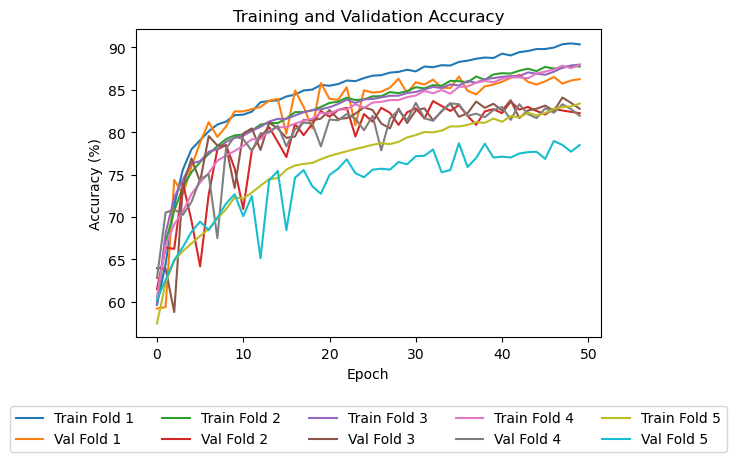

In [11]:
# Plot training and validation accuracy
fig2 = plt.figure(figsize=(6, 4))
plt.title('Training and Validation Accuracy')

for i in range(k_folds):
    plt.plot(train_accs[i], label=f'Train Fold {i+1}')
    plt.plot(val_accs[i], label=f'Val Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()

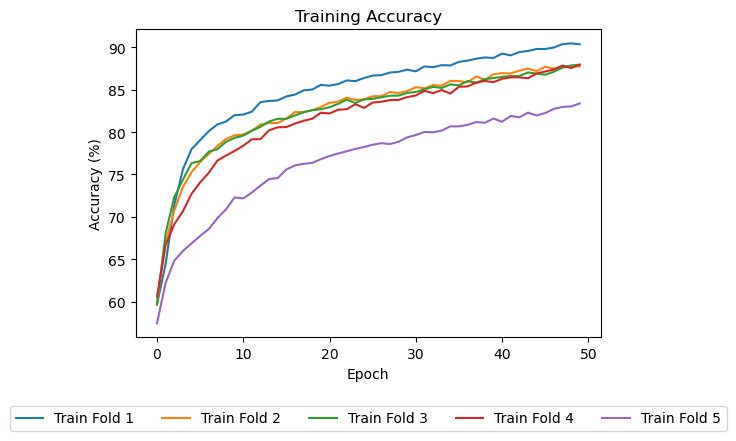

In [15]:
# Plot training and validation accuracy
fig2 = plt.figure(figsize=(6, 4))
plt.title('Training Accuracy')

for i in range(k_folds):
    plt.plot(train_accs[i], label=f'Train Fold {i+1}')
    #plt.plot(val_accs[i], label=f'Val Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()

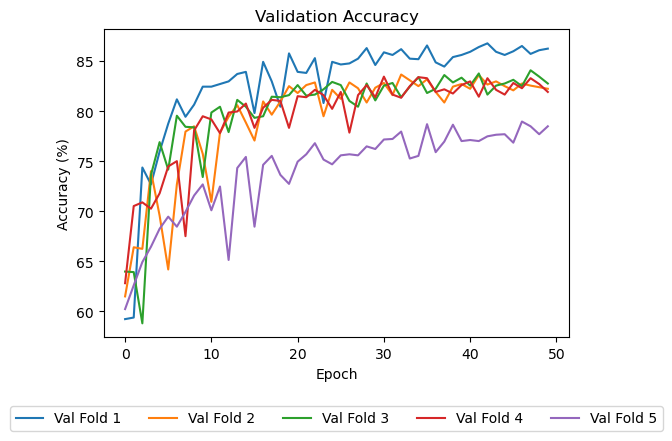

In [16]:
# Plot training and validation accuracy
fig2 = plt.figure(figsize=(6, 4))
plt.title('Validation Accuracy')

for i in range(k_folds):
    #plt.plot(train_accs[i], label=f'Train Fold {i+1}')
    plt.plot(val_accs[i], label=f'Val Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()

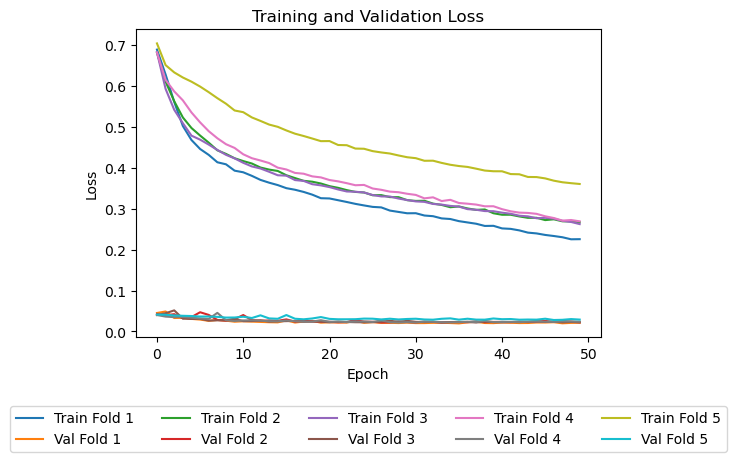

In [12]:
# Plot training and validation loss
fig1 = plt.figure(figsize=(6, 4))
plt.title('Training and Validation Loss')

for i in range(k_folds):
    plt.plot(train_losses[i], label=f'Train Fold {i+1}')
    plt.plot(val_losses[i], label=f'Val Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)

plt.show()

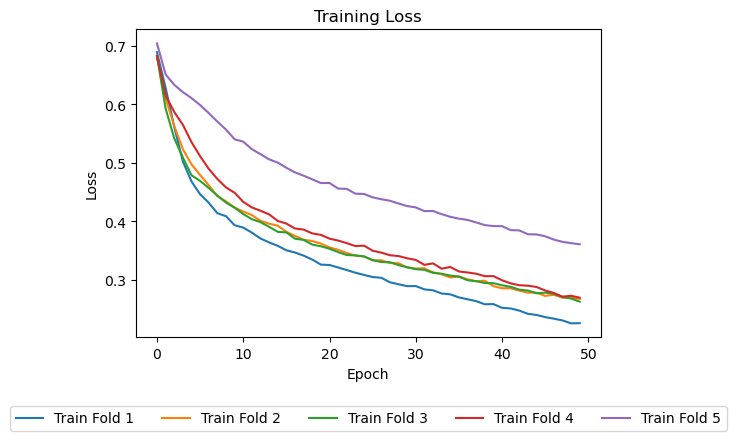

In [14]:
# Plot validation loss
fig1 = plt.figure(figsize=(6, 4))
plt.title('Training Loss')

for i in range(k_folds):
    plt.plot(train_losses[i], label=f'Train Fold {i+1}')
    #plt.plot(val_losses[i], label=f'Val Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)

plt.show()

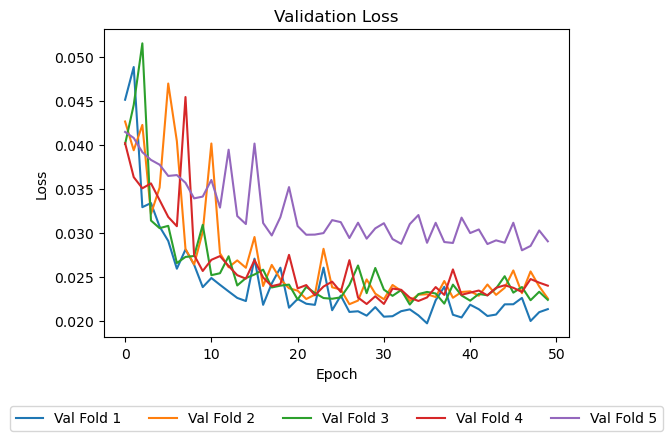

In [13]:
# Plot validation loss
fig1 = plt.figure(figsize=(6, 4))
plt.title('Validation Loss')

for i in range(k_folds):
    #plt.plot(train_losses[i], label=f'Train Fold {i+1}')
    plt.plot(val_losses[i], label=f'Val Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)

plt.show()